# Project 5: Machine Learning on CPU vs GPU and Cloud Deployment

In this project, you will practice with using PyTorch for training ML models and Azure resources for deploying models. Your deliverables will be a set of trained models as well as a public API endpoint that anyone can send their input data to in order to get prediction results from the models.

You can run the following two cells to download the datasets and install relevant packages. On Azure Studio your files will persist so you only need to run these cells once.

In [1]:
!wget -qc http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p5-model-deployment-comparison/p5_handout_v1.tgz -O - | tar -xz -C .
!ls

AlexNet_CPU.pt			      references.txt	  tuned_AlexNet_1.pt
data				      report.md		  tuned_AlexNet_2.pt
LeNet_CPU.pt			      requirements.txt	  tuned_AlexNet_3.pt
LogisticRegression_CPU.pt	      score.py		  tuned_AlexNet_4.pt
models				      scoring_uri.txt	  tuned_AlexNet_5.pt
myenv.yml			      submitter		  tuned_AlexNet_6.pt
p5_model_deployment_comparison.ipynb  test_img.jpg	  tuned_AlexNet_7.pt
references			      tuned_AlexNet_0.pt


In [2]:
!pip install -r requirements.txt

## Files to submit
Because this project involves computationally heavy tasks, we will only run some of your functions on the autograder. For the remaining functions, you will submit the trained model or output files for evaluation. Here is the list of all the files that the `submitter` executable attempts to collect in each submission:

1. **p5_model_deployment_comparison.ipynb** (this notebook)
1. **report.md**
1. **references**
1. models/trained_LogisticRegression.pt (generated in Q9)
1. models/trained_LeNet.pt (generated in Q9)
1. models/tuned_LogisticRegression.pt **or** models/tuned_LeNet.pt **or** models/tuned_AlexNet.pt (generated in Q10)
1. score.py (generated in Q12)
1. scoring_uri.txt (generated in Q12)

The bolded files are required for every submission (although you don't need to completely fill them out until you finish the project). The remaining files are optional, in the sense that the `submitter` script can make a submission without them, but in order to get full score on this project, you should have all 8 files.

## Environment setup

In [3]:
# load necessary modules
import os
import time
import json
import copy
import pickle
import random
import requests
import numpy as np
from PIL import Image
import re

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

We first create a `device` variable which automatically uses GPU, if one is available, and CPU otherwise. This helps us switch between CPU and GPU seamlessly without needing any explicit code changes.

You should assume that all the functions from Q1 - Q11 use GPU by default, unless otherwise specified. Therefore, make sure that the output of the next cell is `device(type='cuda')`. If it is not, you should double check the compute which you are using to run this notebook.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Next, we provide some functions to set the seed of several random generators. We will call these functions at the beginning of every test case to ensure that your code generates consistent output. You do not need to call `set_seed` in any of your implementation code.

In [5]:
GLOBAL_SEED = 1
 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

GLOBAL_WORKER_ID = None
def _init_fn(worker_id):
    global GLOBAL_WORKER_ID
    GLOBAL_WORKER_ID = worker_id
    set_seed(GLOBAL_SEED + worker_id)

set_seed(GLOBAL_SEED)

## Part A: Dataset Overview

The dataset we use here is a subset of [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), which contains 50000 32x32 RGB images belonging to 10 mutually exclusive classes (e,g., plane, car, bird). The dataset is divided into four training batches and one validation batch, each with 10000 images. Each of the batch files contains a dictionary with the following elements:

**Input data** -- a $10000 \times 3072$ matrix of type `uint8s`. Each row of the array stores a flattened 32x32 RGB image as follows:

$$\underbrace{x_1, x_2, \ldots, x_{1024}}_{\text{red channel}} \underbrace{x_{1025}, x_{1026} \ldots x_{2048}}_{\text{green channel}} \underbrace{x_{2049} x_{2050} \ldots x_{3072}}_{\text{blue channel}}$$
Each image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

<p align="center">
    <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png">
</p>

**Output labels** -- a list of $10000$ labels in the range $0-9$. The number at index $i$ indicates the label of the $i$-th image in the input data. We provide a mapping from the label index to the actual label in the list `classes` below.

In [6]:
train_files = ['data/train_batch_1','data/train_batch_2','data/train_batch_3','data/train_batch_4']
val_files = ['data/validation_batch']

## class names
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Question 1: Preparing data for PyTorch

While we can read the data matrices as Numpy arrays, it is generally more efficient to use PyTorch's tensor for datasets of our size. PyTorch has an abstract class called [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) which we can subset to specify our own data preprocessing pipeline. Implement the methods `__init__()`, `__len__()`, and `__getitem__()` in the `ImageDataset` class so that:

* `__init__` reads all the data from a given list of filenames and constructs two instance variables, `self.data` and `self.labels`. `self.data` is a container for the dataset, which should be a 4D Numpy array of shape `(n_images, height, width, n_channels)`. `self.labels` should be a 1D Python list of labels.

* `__len()__` should return the number of images in the dataset.

* `__getitem()__` takes as input an index `idx` and returns the data point at index `idx`, which is a tuple of `(image, label)`, where `image` is a normalized tensor of size `(n_channels, height, width)` and `label` is a label index from 0-9.

**Notes:**

* You can read each batch file using the `pickle` module, with the encoding `latin1`. The content in each file is a dictionary `d`, where `d["data"]` is the input data, represented as a Numpy array of size $10000 \times 3072$, and `d["labels"]` is a list of $10000$ image labels.


*   In `__getitem__()`, after you get an image matrix at the given index from `self.data`, you should transform it using `torchvision.transforms.ToTensor()` and `torchvision.transform.Normalize()`, with `mean = std = 0.5` in each channel. See the [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) documentation for how to use these functions.


In [7]:
class ImageDataset(Dataset):

    def __init__(self, data_files):
        """
        Initializes self.data as a container for the dataset and self.labels as a container for the labels.

        args:
             data_files (List[str]): list of data filenames to read from
        """
        images = []
        labels = []
        for file_name in data_files:
            with open(file_name, "rb") as f:
                obj = pickle.load(f, encoding="latin1")
                labels += obj["labels"]
                images.append(obj["data"])
        num_examples = np.concatenate(images).shape[0]
        self.labels = labels
        self.data = np.transpose(np.concatenate(images).reshape((num_examples, 3, 32, 32)), axes=(0, 2, 3, 1))
    
    
    def __len__(self):
        """
        Get the dataset length.

        return:
            int : the number of images in the dataset
        """
        return self.data.shape[0]


    def __getitem__(self, idx):
        """
        Fetch and transform the data sample at the given index.

        args:
            idx (int): index to get an image data

        return:
            Tuple(img, label):
                img (torch.Tensor) : a normalized tensor of size (n_channels, height, width)
                label (int) : the label of img
        """
        image_obj = self.data[idx, :]
        transform_pipeline = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
            ])
        return transform_pipeline(image_obj), self.labels[idx]


In [8]:
def dataset_test():
    trainset = ImageDataset(train_files)
    valset = ImageDataset(val_files)
    assert set(trainset.labels) == set(range(10))
    assert (trainset.labels[:5] == np.array([6, 9, 9, 4, 1])).all()
    assert trainset.data.shape == (40000, 32, 32, 3)
    assert valset.data.shape == (10000, 32, 32, 3)
    assert len(trainset) == 40000
    assert len(valset) == 10000

    # get training image at index 2
    assert trainset[2][0][0][:3][:,:3].equal(torch.tensor([
        [1.0, 0.9843137264251709,0.9843137264251709 ],
        [1.0, 1.0,1.0],
        [1.0, 0.9921568632125854, 0.9921568632125854]
    ]))
    # get training label at index 2
    assert trainset[2][1] == 9

    # get validation image at index 2
    assert valset[2][0][0][:3][:,:3].equal(torch.tensor([
        [-0.09019607305526733, -0.498039186000824, -0.8509804010391235],
        [-0.10588234663009644, -0.498039186000824, -0.8588235378265381],
        [-0.10588234663009644, -0.5137255191802979, -0.8666666746139526]
    ]))
    # get validation label at index 2
    assert valset[2][1] == 5
    print('All tests passed!')

dataset_test()

All tests passed!


### Question 2: Create Dataloader

Now that we have the training and validation set, the next step is to split them into minibatches, so that we can iterate over each minibatch in our training. PyTorch has a [DataLoader class](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to support this process. Implement the function `get_dataloader` that uses DataLoader to create iterables over the training and validation set with the given batch size.

**Notes**:
* When creating a DataLoader instance, the `shuffle` option should be `True` for the training set and `False` for the validation set.
* You should also set `worker_init_fn` to `_init_fn` and `num_workers` to the provided `num_workers` parameter.

In [9]:
def get_dataloader(trainset, valset = None, batch_size = 64, num_workers = 2):
    """
    Create iterators over the minibatches of the training and validation data.
    
    arg:
        trainset (ImageDataset): instance of ImageDataset with training data
    
    kwargs:
        valset (ImageDataset): instance of ImageDataset with validation data, can be None
        batch_size (int): number of images per minibatch
        num_workers (int): the number of subprocesses used for data loading

    return: 
        Tuple(train_loader, val_loader):
            train_loader (DataLoader): iterable for trainset minibatches
            val_loader (DataLoader): iterable for valset minibatches, or None if valset is None
    """
    train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, worker_init_fn=_init_fn, num_workers=num_workers)
    if valset:
        val_loader = DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, worker_init_fn=_init_fn, num_workers=num_workers)
    else:
        val_loader = None

    return train_loader, val_loader   


In [10]:
def dataloader_test():
    set_seed(GLOBAL_SEED)
    trainset = ImageDataset(train_files)
    valset = ImageDataset(val_files)
    train_loader, val_loader = get_dataloader(trainset, valset)
    
    assert train_loader.dataset == trainset
    assert train_loader.batch_size == 64

    train_images, train_labels = next(iter(train_loader))
    assert train_labels[:5].equal(torch.tensor([0, 6, 7, 4, 6]))

    val_images, val_labels = next(iter(val_loader))
    assert val_labels[4:9].equal(torch.tensor([5, 7, 4, 3, 8]))
    print('All tests passed!')

dataloader_test()

All tests passed!


## Part B: Model Implementation
In this part, we will implement three classifier models using PyTorch, which include a logistic regression model and two convolutional network architectures, LeNet and AlexNet.

To begin, we provide a function that counts the number of parameters in a given model. We will use this to get a better idea of how many parameters are typically required for this kind of image classification task.  



In [11]:
# do not modify this function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Question 3: Logistic regression
Recall from the primer that we can treat a logistic regression model as a neural network with a single linear layer (and softmax activation function). Implement the class `LogisticRegression` with this structure.

**Notes**:
* If the input data to `forward` is a multi-dimensional tensor, it needs to be flattened before being passed to the linear layer.
* The softmax activation function is not a part of the `LogisticRegression` class itself, since it is covered in the cross entropy loss which we will use later in training. Therefore, `LogisticRegression` will only have a linear layer.

In [12]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(np.prod(input_dim), output_dim)
    
    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): an input data point

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        x = torch.flatten(x, start_dim=1)
        return self.output(x)


In [13]:
def test_logistic_regression():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    lr_model = LogisticRegression((3, 32, 32), 10)
    output = lr_model(data).detach().numpy()
    expected_output = np.array([[
        103.10791778564453, -114.89979553222656, 9.040190696716309, 173.601806640625, 58.909786224365234,
        -99.95931243896484, 10.47553539276123, 25.29644012451172, -12.630882263183594, 40.47080993652344
    ]])
    
    assert count_parameters(lr_model) == 30730
    assert output.shape == expected_output.shape
    assert np.allclose(output, expected_output)
    print("All tests passed!")
    
test_logistic_regression()

All tests passed!


### Question 4: LeNet
We now implement a variation of a classic CNN architecture called [LeNet](http://yann.lecun.com/exdb/lenet/), which consists of the following layers:

1. Input layer.
1. Convolutional layer with $K = 6, F = 5, S = 1, P = 0$.
1. ReLU layer.
1. Maxpool layer with $F = S = 2$.
1. Convolutional layer with $K = 16,  F = 5, S = 1, P = 0$.
1. ReLU layer.
1. Maxpool layer with $F = S = 2$.
1. Linear layer with 120 ouput nodes.
1. ReLU layer.
1. Linear layer with 84 output nodes.
1. ReLU layer.
1. Linear layer with `output_dim` output nodes.

Implement the class `LeNet` based on the outline above.

**Notes**:
* Refer to the dimension computations in Section 2.4.2 of the [Deep Learning and Computer Vision primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/m20-foundation-data-science/p5-dl-cv-primer/dl_cv_primer.ipynb) to see how to determine the output dimension of a layer based on its input dimension and hyperparameters.

In [14]:
class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(LeNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim)
            )
        

    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): an input data point

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        out = self.layers(x)
        return out

In [15]:
def test_lenet():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    lenet = LeNet((3, 32, 32), 10)
    expected_output = np.array([[
        -4.061032772064209, 1.5774850845336914, 2.344625949859619, -2.4299728870391846, 3.5291049480438232,
        0.5699751377105713, -2.208556652069092, 4.889535903930664, 2.7112417221069336, -1.9356430768966675
    ]])
    output = lenet(data).detach().numpy()

    assert count_parameters(lenet) == 62006
    assert output.shape == expected_output.shape
    assert np.allclose(output, expected_output)
    print("All tests passed!")
    
test_lenet()

All tests passed!


### Question 5: AlexNet
Our third model is a variation of another CNN architecture called [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), which consists of the following layers:

1. Input layer
1. Convolutional layer, $K = 64, F = 3, S = 2, P = 1$.
1. ReLU layer
1. Maxpool layer, $F = S = 2$.
1. Convolutional layer, $K = 192, F = 3, S = 1, P = 1$.
1. ReLU layer
1. Maxpool layer, $F = S = 2$
1. Convolutional layer, $K = 384, F = 3, S = 1, P = 1$
1. ReLU layer
1. Convolutional layer, $K = 256, F = 3, S = 1, P = 1$
1. ReLU layer
1. Convolutional layer, $K = 256, F = 3, S = 1, P = 1$
1. ReLU layer
1. Maxpool layer, $F = S = 2$
1. Dropout layer
1. Linear layer with 4096 output nodes
1. ReLU layer
1. Dropout layer
1. Linear layer with 4096 output nodes
1. ReLU layer
1. Linear layer with `output_dim` output nodes

**Notes**:
* Note the use of a dropout layer, which randomly zeroes some of the elements of the input tensor with probability $p = 0.5$ during training, in order to prevent overfitting. This is supported by `torch.nn.Dropout`.
* To save memory, you can set `inplace = True` in the ReLU layers (but don't specify this parameter in the Dropout layers).

In [16]:
class AlexNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Initialize the network layers.

        args:
            input_dim (Tuple): the shape (n_channels, height, width) of a sample data point
            output_dim (int): the number of nodes in the output layer
        """
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim)
            )

    def forward(self, x):
        """
        Get the output of the forward pass

        args:
            x (array-like): an input data point

        return:
            tensor[float]: a tensor with output_dim elements, output from the forward pass of this network
        """
        out = self.layers(x)
        return out

In [17]:
def test_alexnet():
    set_seed(GLOBAL_SEED)
    data = (torch.rand(1, 3, 32, 32) * 255)
    alexnet = AlexNet((3, 32, 32), 10)
    expected_output = np.array([[
        -0.2235037386417389, 0.3178039491176605, 0.9120108485221863, -0.5875610709190369, 0.4768661856651306,
        -0.07778273522853851, 0.3449274003505707, 0.9356619715690613, -0.14920833706855774, 0.3794582188129425
    ]])
    output = alexnet(data).detach().numpy()

    assert output.shape == expected_output.shape
    assert count_parameters(alexnet) == 23272266
    assert np.allclose(output, expected_output)
    print("All tests passed!")
    
test_alexnet()

All tests passed!


We see that there is quite a discrepancy between these three models' parameter counts: logistic regression has close to 30 thousands; LeNet has close to 60 thousands, while AlexNet has more than 23 million parameters. Let's see if the additional parameters also correspond to improved performance in our task.

## Part C: Training Preparation

Let's now initialize the components we will need for training our models as global variables. First we will create the training and validation sets as instances of `ImageDataset`. Second, as this is a multi-class classification problem we will use cross entropy as our loss function.

In [18]:
set_seed(GLOBAL_SEED)
full_trainset, full_valset = ImageDataset(train_files), ImageDataset(val_files)
input_dim, output_dim = (3, 32, 32), 10
criterion = nn.CrossEntropyLoss()

### Question 6: Train model for one epoch

We define a helper function to perform model training in one epoch, i.e., going through all minibatches once. Implement the function `train_one_epoch` which loops over all the minibatches in a given DataLoader to train a model and record the average training loss, the training accuracy, as well as training time.

**Note:**
* Before looping through the minibatches, make sure to call `model.train()` to set your model to training mode. While this mode is enabled by default, later on we will alternate between training and validation, so it is good practice to be explicit about the model's mode every time.
* Remember to move all the input data and label to `device` as you loop through `train_loader`. To move a tensor `x` to `device`, you can run `x = x.to(device)` (note the reassignment is necessary here).
* The average training loss is defined as the sum of loss values across all minibatches, divided by the number of minibatches.
* After training in each minibatch, you can compute the number of correctly classified images in that minibatch. The training accuracy is defined as the number of correctly classified images across the entire dataset, divided by the dataset size.
* You should record the start time at the start of the function (with `time.time()`) and end time before the return statement. The difference between these time points is considered the training time.





In [19]:
def train_one_epoch(model, train_loader, optimizer):
    """
    Train a given model on all minibatches provided by a dataloader 
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        train_loader (DataLoader): iterable for trainset minibatches
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim
    
    return: Tuple(avg_train_loss, train_accuracy, train_time)
        avg_train_loss (float): average training loss across batches
        train_accuracy (float): portion of correctly classified images in the training dataset
        train_time (float): the time taken to run this function
    """
    model.train()
    tic = time.time()
    losses = []
    total = 0
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward prop
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Add loss
        losses.append(loss.item())

        # Add accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    toc = time.time()
    
    return np.mean(losses), float(correct / total), float(toc-tic)
    

In [20]:
def test_train_one_epoch():
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    trainset = ImageDataset([train_files[0]])
    train_loader, _ = get_dataloader(trainset)
    avg_train_loss, train_accuracy, train_time = train_one_epoch(model, train_loader, optimizer)

    assert np.allclose(avg_train_loss, 1.9182772309916793)
    assert train_accuracy == 0.3348
    print('All tests passed!')

test_train_one_epoch()

All tests passed!


### Question 7: Validate the trained model

After training a model, we need to evaluate its generalizability with the validation data. Given a trained model and validation dataloader, implement the function `validate_model()` that uses the trained model to predict the validation labels, returning the validation loss, accuracy and running time.

**Note:**

* Similar to `train_one_epoch`, you should record the start time at the begining and end time before returning, then calculate their difference as the validation time.
* Before looping through the minibatches, make sure to call `model.eval()` to set your model to evaluation mode, and also call `torch.no_grad()` to disable gradient computation.
* Remember to move all the input data and label to `device` as you loop through `val_loader`. To move a tensor `x` to `device`, you can run `x = x.to(device)`.


In [21]:
def validate_model(model, val_loader):  
    """
    Validate a given model with a validation dataloader.
    
    args:
        model (nn.Module): the trained model 
        val_loader (DataLoader): iterable for valset minibatches

    return: Tuple(avg_val_loss, val_accuracy, val_time)
        avg_val_loss (float): average validation loss across batches
        val_accuracy (float): portion of correctly classified images in the validation dataset
        val_time (float): the time taken to run this function
    """
    model.eval()
    tic = time.time()
    with torch.no_grad():
        correct = 0
        total = 0
        losses=[]
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Add loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Add accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    toc = time.time()
    return np.mean(losses), float(correct / total), float(toc-tic)


In [22]:
def test_validate_model():
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    trainset = ImageDataset([train_files[0]])
    valset = ImageDataset([val_files[0]])
    train_loader, val_loader = get_dataloader(trainset, valset)
    train_one_epoch(model, train_loader, optimizer)

    avg_val_loss, val_accuracy, val_time = validate_model(model, val_loader)
    assert np.allclose(avg_val_loss, 1.880957977786945)
    assert val_accuracy == 0.3567
    print('All tests passed!')

test_validate_model()

All tests passed!


### Question 8: Train model for mutiple epochs

We usually train a model for multiple epochs to get better results. Implement the `train_model` function that trains a given model for `n_epochs` times, evaluates its performance at each epoch, and returns the best state of the model (i.e., the state at the epoch when the best validation accuracy is yielded).

**Notes**:
* If two model states at two different epoch numbers yield the same best validation accuracy, pick the state corresponding to the *lower* epoch number. Also note that the epoch numbers should be indexed from 1, not 0 (i.e., the first epoch is called epoch 1).
* To save a model state, you can make a deep copy of its `state_dict()`. To load a model state, create a new instance variable of the same model class, and call `.load_state_dict()`.
* This function has a `scheduler` parameter, which is used to dynamically adjust the learning rate during training. You can see its use case in the [official documentation](https://pytorch.org/docs/stable/optim.html). In summary, if `scheduler` is not `None`, `scheduler.step()` should be called once every epoch *after* all the training iterations in that epoch have finished. In later questions, you will get to specify your own `scheduler`.
* We also provide a `verbose` flag. If you would like to add print debugging messages during model training, simply precede each print statement with an `if verbose` check, for example

```python
if verbose:
    print("Training accuracy is", train_acc)
    print("Validation accuracy is", val_acc)
```
During your work you can set `verbose = True` to help with debugging; our autograder will only call `train_model` with `verbose = False`, so that your printout messages do not interfere with the grading.

* You can record the total time by summing over all the time values returned by `train_one_epoch` and `validate_models`.

In [23]:
def train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler = None, verbose = False):
    """
    Train the model for several epochs, recording the best model state and training / validation time and performance
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        n_epochs (int): the number of epochs to train for
        train_loader (DataLoader): iterable for trainset minibatches
        val_loader (DataLoader): iterable for valset minibatches
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim

    kwargs:
        scheduler (optim.lr_scheduler): a PyTorch scheduler that can adjust the learning rates during training
        verbose (bool): a flag that indicates whether print statements should be executed

    return:
        Tuple(best_acc_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time)
            best_acc_model (nn.Module): the model with the weight parameters that yield the best validation accuracy across all epochs
            best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
            train_accs (List[float]): list of average training accuracy in each epoch
            train_losses (List[float]): list of average training loss in each epoch
            val_accs (List[float]): list of validation accuracy in each epoch
            total_time (float): the sum of train time and validation time across all epochs
    """
    # Inits
    epoch = 1
    best_acc_model = model
    best_acc_epoch_num = 1
    best_val_acc = 0.0
    train_accs = []
    train_losses = []
    val_accs = []
    tic = time.time()

    while epoch <= n_epochs:
        avg_train_loss, train_accuracy, _ = train_one_epoch(model, train_loader, optimizer)
        _, val_accuracy, _ = validate_model(model, val_loader)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        train_losses.append(avg_train_loss)

        if val_accuracy > best_val_acc:
            best_acc_model = model
            best_acc_epoch_num = epoch
            best_val_acc = val_accuracy
        
        if verbose:
            print("Training accuracy is", train_accuracy)
            print("Validation accuracy is", val_accuracy)
        
        if scheduler:
            scheduler.step()
        epoch += 1

    toc = time.time()
    return best_acc_model, best_acc_epoch_num, train_accs, train_losses, val_accs, toc-tic

In [24]:
def test_train_model():
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    model.to(device)
    
    trainset = ImageDataset([train_files[0]])
    valset = ImageDataset([val_files[0]])
    train_loader, val_loader = get_dataloader(trainset, valset)
    
    # no scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    best_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time = \
        train_model(model, 5, train_loader, val_loader, optimizer, scheduler=None, verbose = True)
    assert best_acc_epoch_num == 2
    assert train_accs == [0.3348, 0.3787, 0.4044, 0.4154, 0.4293]
    assert np.allclose(train_losses, [
        1.9182772309916793, 1.8017016231634055, 1.7368443019830497,
        1.7078009145275044, 1.674495145773432
    ])
    assert val_accs == [0.3567, 0.3717, 0.3611, 0.3643, 0.3658]
    
    # with scheduler
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 * epoch)
    best_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time = \
        train_model(model, 5, train_loader, val_loader, optimizer, scheduler=scheduler, verbose = True)
    
    assert best_acc_epoch_num == 2
    assert train_accs == [0.0859, 0.3318, 0.3634, 0.3524, 0.3644]
    assert np.allclose(train_losses, [
        2.392915362765075, 1.9284085969256748, 1.8689316921173387,
        2.004910013478273, 1.978499769405195
    ])
    assert val_accs == [0.0881, 0.3665, 0.3416, 0.334, 0.3125]
    print('All tests passed!')

test_train_model()

Training accuracy is 0.3348
Validation accuracy is 0.3567
Training accuracy is 0.3787
Validation accuracy is 0.3717
Training accuracy is 0.4044
Validation accuracy is 0.3611
Training accuracy is 0.4154
Validation accuracy is 0.3643
Training accuracy is 0.4293
Validation accuracy is 0.3658
Training accuracy is 0.0859
Validation accuracy is 0.0881
Training accuracy is 0.3318
Validation accuracy is 0.3665
Training accuracy is 0.3634
Validation accuracy is 0.3416
Training accuracy is 0.3524
Validation accuracy is 0.334
Training accuracy is 0.3644
Validation accuracy is 0.3125
All tests passed!


## Part D: Model Training and Fine-tuning
In this part, we will use more computational resources to train our models properly and get better accuracy. You will also get to explore the hyperparameter options to produce a trained model that meets a given performance requirement.

### Question 9: Train and save model to file
Implement the function `train_and_save_model` which, given a set of hyperparameters, trains the model on all of the $40000$ training data images and saves the trained model to a file in the `models` directory. The function takes as input a model instance of class `LogisticRegression`, `LeNet` or `AlexNet`. It also takes as input an optional parameter `filepath`, which specifies the path of the file that contains the saved model; if this parameter is not provided, the default path should be `"models/trained_{classname}.pt"`, for example `"models/trained_AlexNet.pt"`.

**Notes**:
* You will run this function on  both GPU and CPU and record the outcomes in each case. Therefore, remember to call `model.to(device)` at the beginning of the function.
* Recall that we already initialized `full_trainset` and `full_valset` as global instances of `ImageDataset` earlier. Therefore, you only need to create the DataLoader iterables based on the given `batch_size` in this function.
* When saving a model to a file, you only need to save its `state_dict()`, not the entire model. See the [official guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) here for more details. 
* To get the class name of an instance variable `v`, you can call `v.__class__.__name__`.

In [24]:
def train_and_save_model(model, optimizer, batch_size=64, n_epochs=5, scheduler=None, filepath=None, verbose=False):
    """
    Train a model based on the given model name, batch size, epoch number, optimizer and scheduler.
    Then save the trained model's state_dict to a file. 
    
    args:
        model (nn.Module): an instance of a model class (LogisticRegression, LeNet or AlexNet)
        optimizer (optim.Optimizer): an instance of an optimizer class in torch.optim
    
    kwargs:
        batch_size (int): the minibatch size for DataLoader
        n_epochs (int): the number of epochs to train for
        scheduler (optim.lr_scheduler): a PyTorch scheduler that can adjust the learning rates during training
        filepath (str): the path of the file to save the trained model to
        verbose (bool): a flag that indicates whether print statements should be executed

    return: Tuple(best_acc_model, best_acc_epoch_num, train_accs, val_accs, total_time)
        best_acc_model (nn.Module): the model with the weight parameters that yield the best validation accuracy across all epochs
        best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
        train_accs (List[float]): list of average training accuracy in each epoch
        val_accs (List[float]): list of validation accuracy in each epoch 
        total_time (float): the sum of train time and validation time across all epochs, returned from train_model
    """
    # Inits
    model.to(device)
    train_loader, val_loader = get_dataloader(full_trainset, full_valset, batch_size=batch_size)

    best_acc_model, best_acc_epoch_num, train_accs, train_losses, val_accs, total_time = train_model(model, n_epochs, train_loader, val_loader, optimizer, scheduler, verbose)

    if not filepath:
        filepath = "models/trained_" + model.__class__.__name__ + ".pt"
    torch.save(best_acc_model.state_dict(), filepath)
    
    return best_acc_model, best_acc_epoch_num, train_accs, val_accs, total_time


In [39]:
def test_train_and_save_model_gpu():
    # train_and_save_model_gpu should be run on GPU in this test function
    assert device.type == "cuda"

    # logistic regression performance
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, logistic_best_epoch, logistic_train_accs, logistic_val_accs, logistic_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert logistic_best_epoch == 5
    assert logistic_train_accs == [0.356, 0.38465, 0.39655, 0.400825, 0.400975]
    assert logistic_val_accs == [0.3531, 0.3728, 0.3694, 0.3705, 0.3887]
    assert os.path.isfile("models/trained_LogisticRegression.pt")

    # LeNet performance
    set_seed(GLOBAL_SEED)
    model = LeNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, lenet_best_epoch, lenet_train_accs, lenet_val_accs, lenet_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert lenet_best_epoch == 5
    assert lenet_train_accs == [0.367375, 0.48845, 0.5379, 0.564225, 0.58855], lenet_train_accs
    assert lenet_val_accs == [0.4484, 0.517, 0.5494, 0.5513, 0.5764]
    assert os.path.isfile("models/trained_LeNet.pt")

    # AlexNet performance
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, alexnet_best_epoch, alexnet_train_accs, alexnet_val_accs, alexnet_time = \
         train_and_save_model(model, optimizer, n_epochs = 5, verbose = True)
    assert alexnet_best_epoch == 5
    assert alexnet_train_accs == [0.3191, 0.4793, 0.5624, 0.61445, 0.6569]
    assert alexnet_val_accs == [0.4337, 0.5455, 0.6042, 0.6333, 0.6592]
    assert os.path.isfile("models/trained_AlexNet.pt")

    print("All tests passed!")
    print("Logistic regression on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        logistic_train_accs[logistic_best_epoch-1], logistic_val_accs[logistic_best_epoch-1], logistic_time
    ))
    print("LeNet on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        lenet_train_accs[lenet_best_epoch-1], lenet_val_accs[lenet_best_epoch-1], lenet_time
    ))
    print("AlexNet on GPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        alexnet_train_accs[alexnet_best_epoch-1], alexnet_val_accs[alexnet_best_epoch-1], alexnet_time
    ))

test_train_and_save_model_gpu()

Training accuracy is 0.356
Validation accuracy is 0.3531
Training accuracy is 0.38465
Validation accuracy is 0.3728
Training accuracy is 0.39655
Validation accuracy is 0.3694
Training accuracy is 0.400825
Validation accuracy is 0.3705
Training accuracy is 0.400975
Validation accuracy is 0.3887
Training accuracy is 0.367375
Validation accuracy is 0.4484
Training accuracy is 0.48845
Validation accuracy is 0.517
Training accuracy is 0.5379
Validation accuracy is 0.5494
Training accuracy is 0.564225
Validation accuracy is 0.5513
Training accuracy is 0.58855
Validation accuracy is 0.5764
Training accuracy is 0.3191
Validation accuracy is 0.4337
Training accuracy is 0.4793
Validation accuracy is 0.5455
Training accuracy is 0.5624
Validation accuracy is 0.6042
Training accuracy is 0.61445
Validation accuracy is 0.6333
Training accuracy is 0.6569
Validation accuracy is 0.6592
All tests passed!
Logistic regression on GPU:
Best model's train acc: 0.400975, Best model's val acc: 0.3887, Training 

You should now open `report.md` and record the time and accuracy of each of our 3 models; this information is printed after the message "All tests passed!" in `test_train_and_save_model_gpu`.

Next, let's also see how long the same training process would take on CPU. Run the following function and record each model's performance and time taken in `report.md`:

In [33]:
def test_train_and_save_model_CPU():
    global device
    device = torch.device("cpu")

    # train_and_save_model_cpu should be run on CPU in this test function
    assert device.type == "cpu"

    # logistic regression performance
    set_seed(GLOBAL_SEED)
    model = LogisticRegression(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, logistic_best_epoch, logistic_train_accs, logistic_val_accs, logistic_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, filepath = "LogisticRegression_CPU.pt", verbose = True)

    # LeNet performance
    set_seed(GLOBAL_SEED)
    model = LeNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, lenet_best_epoch, lenet_train_accs, lenet_val_accs, lenet_time = \
        train_and_save_model(model, optimizer, n_epochs = 5, filepath = "LeNet_CPU.pt", verbose = True)

    # AlexNet performance
    set_seed(GLOBAL_SEED)
    model = AlexNet(input_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    _, alexnet_best_epoch, alexnet_train_accs, alexnet_val_accs, alexnet_time = \
         train_and_save_model(model, optimizer, n_epochs = 5, filepath = "AlexNet_CPU.pt", verbose = True)

    print("Logistic regression on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        logistic_train_accs[logistic_best_epoch-1], logistic_val_accs[logistic_best_epoch-1], logistic_time
    ))
    print("LeNet on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        lenet_train_accs[lenet_best_epoch-1], lenet_val_accs[lenet_best_epoch-1], lenet_time
    ))
    print("AlexNet on CPU:")
    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        alexnet_train_accs[alexnet_best_epoch-1], alexnet_val_accs[alexnet_best_epoch-1], alexnet_time
    ))

test_train_and_save_model_CPU()

Training accuracy is 0.356
Validation accuracy is 0.3531
Training accuracy is 0.38465
Validation accuracy is 0.3728
Training accuracy is 0.39655
Validation accuracy is 0.3694
Training accuracy is 0.400825
Validation accuracy is 0.3705
Training accuracy is 0.400975
Validation accuracy is 0.3887
Training accuracy is 0.366275
Validation accuracy is 0.4499
Training accuracy is 0.489425
Validation accuracy is 0.5162
Training accuracy is 0.5369
Validation accuracy is 0.5506
Training accuracy is 0.565025
Validation accuracy is 0.5522
Training accuracy is 0.587775
Validation accuracy is 0.5763
Training accuracy is 0.311675
Validation accuracy is 0.4362
Training accuracy is 0.48095
Validation accuracy is 0.5306
Training accuracy is 0.564175
Validation accuracy is 0.5672
Training accuracy is 0.613425
Validation accuracy is 0.6251
Training accuracy is 0.65
Validation accuracy is 0.6351
Logistic regression on CPU:
Best model's train acc: 0.400975, Best model's val acc: 0.3887, Training + Validatio

Now let's switch back to using GPU for our next task.

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Question 10: Fine-tune your own model
Note that so far we have only run the three models on a fixed set of hyperparameters with very few epochs, and so unsurprisingly, the model performances are fairly mediocre. However, with a proper setting of hyperparameters, optimizer and (possibly) scheduler, our models can achieve much higher training and validation accuracy.

Now it is time for your own exploration! We have provided a template function `fine_tune_model` for you, where you can specify the model class and relevant hyparameter choices. After filling in these values, run `fine_tune_model_test` to check if your model choice meets the performance criteria: we require a training accuracy of **at least 80%** and a validation accuracy of **at least 70%**.

**Notes**:
* You can choose to fine-tune either a LogisticRegression, LeNet or AlexNet model (only **one** fine-tuned model is needed). Do not modify the class implementations in Q3/Q4/Q5, or the data preprocessing steps in Q1. Instead, only fill in the variables that are currently set to `None` in `fine_tune_model`.
* When `fine_tune_model` finishes running, it will also save the trained model to a file with the name `tuned_{classname}_{index}.pt`, for example `tuned_AlexNet_5.pt`. The index will be incremented automatically depending on how many tuned models of the same class are already present (this is to prevent a new model overwriting any previously saved model file). We have provided the code to implement this functionality for you.
* If the model training takes a long time to run, you can follow the `tmux` instructions in the final section of the [Machine Learning on Azure primer](https://theproject.zone/m20-foundation-data-science/p5-machine-learning-azure-primer) to run your code in the background. In this case, make sure you have a call to `fine_tune_model()` in the global namespace so that the tuning code gets run from the Azure terminal.

In [26]:
def fine_tune_model():
    """
    Fine tune a model instance of LogisticRegression or LeNet or AlexNet.

    return: Tuple(best_acc_model, best_acc_epoch_num, train_accs, val_accs, total_time)
        best_acc_model (nn.Module): the model state with the weight parameters that yield the best validation accuracy across all epochs
        best_acc_epoch_num (int): the epoch number where the best validation accuracy occurs (indexed from 1)
        train_accs (List[float]): list of average training accuracy in each epoch
        val_accs (List[float]): list of validation accuracy in each epoch
        total_time (float): the sum of train time and validation time across all epochs, returned from train_and_save_model
    """ 
    # initialize your model here
    model = AlexNet(input_dim, output_dim)
    model.to(device)
    
    # specify your optimizer and scheduler here
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 5e-4)
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: 0.95 * epoch if epoch > 7 else epoch)
    scheduler = None
    
    # specify your hyperparameters here
    batch_size = 128
    n_epochs = 15
    
    # do not modify the remaining code
    classname = model.__class__.__name__
    index = 0
    while os.path.isfile(f"tuned_{classname}_{index}.pt"):
        index += 1
    return train_and_save_model(
        model, optimizer, batch_size, n_epochs, scheduler, f"tuned_{classname}_{index}.pt", verbose = True
    )

In [41]:
def test_fine_tune_model():
    set_seed(GLOBAL_SEED)
    model, best_acc_epoch_num, train_accs, val_accs, total_time = fine_tune_model()

    print("Best model's train acc: {}, Best model's val acc: {}, Training + Validation time: {}".format(
        train_accs[best_acc_epoch_num-1], val_accs[best_acc_epoch_num-1], total_time
    ))

    # check performance requirement
    assert train_accs[best_acc_epoch_num-1] >= 0.80
    assert val_accs[best_acc_epoch_num-1] >= 0.70

    # check that network structures are not changed
    n_params = count_parameters(model)
    if isinstance(model, LogisticRegression):
        assert n_params == 30730
    elif isinstance(model, LeNet):
        assert n_params == 62006
    elif isinstance(model, AlexNet):
        assert n_params == 23272266
    else:
        assert False, "Unrecognized model class"

    print("All tests passed!")

test_fine_tune_model()

Training accuracy is 0.291525
Validation accuracy is 0.3892
Training accuracy is 0.4618
Validation accuracy is 0.4896
Training accuracy is 0.547725
Validation accuracy is 0.5556
Training accuracy is 0.601975
Validation accuracy is 0.6301
Training accuracy is 0.643375
Validation accuracy is 0.6214
Training accuracy is 0.677925
Validation accuracy is 0.6572
Training accuracy is 0.7049
Validation accuracy is 0.6829
Training accuracy is 0.7297
Validation accuracy is 0.6973
Training accuracy is 0.75055
Validation accuracy is 0.6937
Training accuracy is 0.771275
Validation accuracy is 0.7109
Training accuracy is 0.78495
Validation accuracy is 0.711
Training accuracy is 0.800875
Validation accuracy is 0.7028
Training accuracy is 0.82005
Validation accuracy is 0.7222
Training accuracy is 0.83115
Validation accuracy is 0.7169
Training accuracy is 0.84365
Validation accuracy is 0.7215
Best model's train acc: 0.82005, Best model's val acc: 0.7222, Training + Validation time: 298.60454845428467
Al

This concludes our model training section! You should now have filled in all of the required details in `report.md`. Look at the differences in runtime and in performance between CPU and GPU; what do you notice? How much improvement does your fine tuned model provide, compared to the 3 base models training on 5 epochs? What is the cost of this improvement, in terms of runtime and cloud budget? For reference, a `Standard_D3_V2` CPU costs \$0.293/hour, while a `Standard_NC6` GPU costs \$0.90/hour.

We often hear about the runtime vs space tradeoff in computer science, or bias vs variance tradeoff in machine learning. In a practical business setting, an equally important consideration is the cost vs performance tradeoff. Depending on your goals and constraints, you will need to decide on when it is suitable to investigate more budget into performance improvement, and whether the added improvement is worth the cost.

To submit your tuned model for Q10, enter the name of the file that contains your **best fine tuned model** to the variable `tuned_model_file` below, and execute the code cell. This will clean the model file name and make a copy of it in the `models` directory. Then you can run the `submitter` executable; it will automatically pick up all the files in your `models` directory to submit:

In [42]:
# enter the name of your tuned model file here
tuned_model_file = "tuned_AlexNet_7.pt"

# remove trailing index from filename
renamed_model_file = re.sub("_\d+", "", tuned_model_file)
assert renamed_model_file in ["tuned_LogisticRegression.pt", "tuned_LeNet.pt", "tuned_AlexNet.pt"]

# copy the file to the models directory
os.system(f"cp {tuned_model_file} models/{renamed_model_file}")

# check that the models directory only has four model files
assert len([file for file in os.listdir("models") if file.endswith(".pt")]) == 4

## Part E: Deployment 
In the final part of Project 5, you will deploy your trained models to an API endpoint, so that if other people need to use your models' inferences, they can simply send an HTTP request to your API. Fortunately, Azure already supports a [streamlined deployment process](https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-deploy-models-with-aml) that we can mostly follow; the only part where we need to customize is how to initialize the models and process the inputs.

In this section, we will provide most of the setup code for you. Look out for the occurences of the `None` or `pass` keywords; these typically indicate the content that *you need to fill in*.

### Question 11: Construct JSON responses to input data
Before setting up the deployment, let's think about what our inputs and outputs should look like. Each incoming HTTP POST request will contain an image matrix in the same format as CIFAR-10 images. We also have four trained models in the `models` directory. For each model, we want to return (1) its predicted label for the input image, and (2) the probability that it thinks it is correct.

To get these outputs, recall that each of our models has a 10-node linear output layer, i.e., the output from the forward pass is a tensor of 10 scalars $o_1, o_2, \ldots, o_{10}$. We can then use the softmax function to compute the probability that our model thinks label $i$ is correct:

$$P(y = i \mid x) = \frac{\exp(o_i)}{\sum_{j=1}^{10} \exp(o_j)}.$$

and the final predicted label is the one that has the highest probability: $\hat y = \underset{i}{\operatorname{argmax}} P(y = i \mid x).$

Because we have multiple models, we would like the return format to be a dictionary as follows:

```python
{
    "model1" : {"label" : "car", "probability" : "0.1234" },
    "model2" : {"label" : "truck", "probability" : "0.5678" },
    ...
}
```
where `"model1", "model2"` are the provided model names.

Implement the function `get_predictions` that takes as input (1) an input image data, and (2) a mapping from model name to model instance. It then outputs a dictionary with the format above, where the keys are all the model names from the input mapping, and the probability values are **rounded to 4 decimal digits**.

**Notes**:
* You should convert the input `data` to a tensor and send it to `device`, so that this function can work on both GPU and CPU (later on we will only do the deployment on CPU).
* You should use `nn.Softmax` or `nn.functional.softmax` to compute $P(y = i \mid x)$.
* To get consistent output with the autograder, use `str(round(p, 4))` for the probability values in the returned dictionary.
* Once you have identified the index of the predicted label $\hat y$, use the `classes` list we provide at the beginning to retrieve the actual label. As a reminder, here is the definition of `classes`:

```python
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
```
so $\hat y = 0$ corresponds to the label `plane`, $\hat y = 1$ to `car`, and so on.





In [27]:
def get_predictions(data, model_mapping):
    """
    Generate the predicted label of each model in the provided model mapping for an input image.

    args:
        data (np.array) : a single image data with shape (1, 3, 32, 32)
        model_mapping (Dict[str, nn.Module]) : a mapping between a string model name and a model object,
            which is an instance of either LogisticRegression, LeNet or AlexNet
    
    return:
        Dict[str, Dict[str, str]]: a dictionary where each key is a model name from model_mapping, and each value 
            is an inner dictionary with format {"label" : str, "probability" : str}
    """
    results = {}
    data = torch.from_numpy(data)
    data = data.to(device)
    for model_name, model in model_mapping.items():
        model.eval()
        results[model_name] = {}
        with torch.no_grad():
            outputs = nn.functional.softmax(model(data), 1)
            _, predicted = torch.max(outputs.data, 1)
            results[model_name]["label"] = classes[predicted]
            results[model_name]["probability"] = str(round(torch.max(outputs).item(), 4))
    return results

In [28]:
def test_get_predictions():
    # load 2 models into model_mapping
    logit = LogisticRegression(input_dim, output_dim).to(device)
    lenet = LeNet(input_dim, output_dim).to(device)
    logit.load_state_dict(torch.load("models/trained_LogisticRegression.pt", map_location = device))
    lenet.load_state_dict(torch.load("models/trained_LeNet.pt", map_location = device))
    model_mapping = {"LogisticRegression" : logit, "LeNet" : lenet}
    
    data = full_valset[0][0].reshape(1, 3, 32, 32).numpy()
    predictions = get_predictions(data, model_mapping)
    assert predictions == {
        "LogisticRegression" : {"label" : "truck", "probability" : "0.3737"},
        "LeNet" : {"label" : "car", "probability" : "0.9598"}
    }
    print("All tests passed!")

test_get_predictions()

All tests passed!


Now let's begin the environment setup for model deployment. First, we import the relevant Azure SDK packages. These should already be pre-installed when you run the notebook on Azure Studio.

In [29]:
import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.model import Model
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

**Initialize workspace**

Next, we will programmatically get information about the [workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace%28class%29?view=azure-ml-py) that you created to host this current compute and notebook. This can be done by simply calling `Workspace.from_config()`. The first time you run this, you may see an output message such as

```
Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code XYZ to authenticate.
```

Simply follow the steps in the message.

In [30]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: project5
Azure region: eastus
Subscription id: 5b3a3039-a86c-4c9a-9463-b8a5c02b13c8
Resource group: p5



**Register model**


Next, we register the four model files stored in the `models` folder by calling [Model.register()](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.model?view=azure-ml-py#register-workspace--model-path--model-name--tags-none--properties-none--description-none--datasets-none--model-framework-none--model-framework-version-none--child-paths-none-)
and set `model_name = 'deployment_models'`.

In addition to the content of the `models` folder itself, your registered models will also store model metadata -- model description, tags, and framework information -- that will be useful when managing and deploying models in your workspace. Using tags, for instance, you can categorize your models and apply filters when listing models in your workspace.

In [31]:
workspace_model = Model.register(
    workspace = ws, model_path ="models",
    model_name = "deployment_models",
    description = "LogisticRegression, LeNet, AlexNet model and the best fine-tuned model"
)

Registering model deployment_models


**Deploy model as web service**

After registering the models to the workspace, we will deploy the models as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). For more information on deploying models using Azure ML, refer to [this official documentation](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where). In a practical setting, [Azure Kubernetes Service](https://azure.microsoft.com/en-us/services/kubernetes-service/) (AKS) would offer more robustness than ACI, but is also more complex to set up. We will stick to ACI in this project.

### Question 12: Create scoring script and API endpoint

Now comes the main deployment task: you need to specify how the models are initialized and how to process input data. The basic structure will be as follows:

* You should maintain a global dictionary `model_mapping` that maps the model file names to their corresponding loaded models. For example it would map the string `"trained_LeNet.pt"` to an instance of the class `LeNet` that is loaded from this file.
* The `init()` function will initialize `model_mapping`. The model file names will be all of the files that are in the directory returned by `Model.get_model_path('deployment_models')`.
* The `run()` function takes as input an image data matrix with shape `(1, 3, 32, 32)` and outputs all the model predictions for this image. This is equivalent to `get_predictions`; so we can just return the output of `get_predictions` inside `run`; however, you will need to **copy** the implementation code of `get_predictions` from Q11 to this cell.
* `LogisticRegression`: copy your implementation of the class `LogisticRegression` from Q3.
* `LeNet`: copy your implementation of the class `LeNet` from Q4.
* `AlexNet`: copy your implementation of the class `AlexNet` from Q5.

**Notes**:
* Copying here means you should copy and paste the actual implementation code.
* Note that we trained the models on GPU but are deploying on CPU. Therefore, when you load the model from files in `init`, remember to specify `map_location = device` (see the [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more details).

In [57]:
%%writefile ./score.py
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from azureml.core.model import Model
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType

# do not modify this code
device = torch.device("cpu")
input_dim, output_dim = ((3, 32, 32), 10)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_mapping = {}


#########################################
#### Primary functions for score.py #####
#########################################

def init():
    """
    Load registered models from the directory Model.get_model_path('deployment_models')
    and initialize model_mapping as a mapping from model file name to loaded model.
    
    When this function finishes, model_mapping should look like
    
    {
        "trained_LogisticRegression.pt" : <loaded model from trained_LogisticRegression.pt>,
        "trained_LeNet.pt" : <loaded model from trained_LeNet.pt>,
        "trained_AlexNet.pt" : <loaded model from trained_AlexNet.pt>,
        "tuned_{classname}.pt" : <loaded model from tuned_{classname}.pt>
    }
    
    Here classname should be either LogisticRegression, LeNet or AlexNet.
    You can use the classname value to decide which class the tuned model is an instance of.
    """
    logit = LogisticRegression(input_dim, output_dim).to(device)
    logit.load_state_dict(torch.load(Model.get_model_path("deployment_models") + "/trained_LogisticRegression.pt", map_location = device))
    lenet = LeNet(input_dim, output_dim).to(device)
    lenet.load_state_dict(torch.load(Model.get_model_path("deployment_models") + "/trained_LeNet.pt", map_location = device))
    alexnet = AlexNet(input_dim, output_dim).to(device)
    alexnet.load_state_dict(torch.load(Model.get_model_path("deployment_models") + "/trained_AlexNet.pt", map_location = device))
    tuned = AlexNet(input_dim, output_dim).to(device)
    tuned.load_state_dict(torch.load(Model.get_model_path("deployment_models") + "/tuned_AlexNet.pt", map_location = device))
    
    global model_mapping
    model_mapping = {"trained_LogisticRegression.pt" : logit, 
                     "trained_LeNet.pt" : lenet,
                     "trained_AlexNet.pt" : alexnet,
                     "tuned_AlexNet.pt" : tuned
                     }

# do not modify this code
input_sample = np.array(range(3072)).reshape([1,3,32,32]).astype('float32')
output_sample = np.array([1])

@input_schema('data', NumpyParameterType(input_sample,enforce_shape=False))
@output_schema(NumpyParameterType(output_sample))

def run(data):
    # do not modify this code
    return get_predictions(data, model_mapping)

def get_predictions(data, model_mapping):
    """
    Copy the code from get_predictions (Q11) here
    """
    results = {}
    data = torch.from_numpy(data)
    data = data.to(device)
    for model_name, model in model_mapping.items():
        print(model_name)
        model.eval()
        results[model_name] = {}
        with torch.no_grad():
            outputs = nn.functional.softmax(model(data), 1)
            print(outputs)
            _, predicted = torch.max(outputs.data, 1)
            results[model_name]["label"] = classes[predicted]
            results[model_name]["probability"] = str(round(torch.max(outputs).item(), 4))
    return results

#########################################
## Copy of model class implementations ##
#########################################

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in LogisticRegression here
        """
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(np.prod(input_dim), output_dim)
    
    def forward(self, x):
        """
        Copy the code from forward in LogisticRegression here
        """
        x = torch.flatten(x, start_dim=1)
        return self.output(x)

class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in LeNet here
        """
        super(LeNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, output_dim)
            )

    def forward(self, x):
        """
        Copy the code from forward in LeNet here
        """
        out = self.layers(x)
        return out


class AlexNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Copy the code from __init__ in AlexNet here
        """
        super(AlexNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
            
            nn.Flatten(),
            nn.Linear(1024, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim)
            )

    def forward(self, x):
        """
        Copy the code from forward in AlexNet here
        """
        out = self.layers(x)
        return out

Overwriting ./score.py


You may be wondering why we need to copy the code implementations of `get_predictions()` and the model classes to the above cell. The reason is that the `init()` and `run()` functions are not supposed to be in this notebook, but in a separate file called `score.py`, which we will later provide to Azure. Instead of manually creating `score.py` and copying code from this notebook over, we can make use of the magic command `%%writecell` in IPython to write a cell content to file. If you run the above cell, you will notice that a file called `score.py` is automatically generated with the same content as what is in that cell:

In [59]:
!cat score.py

import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from azureml.core.model import Model
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType

# do not modify this code
device = torch.device("cpu")
input_dim, output_dim = ((3, 32, 32), 10)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
model_mapping = {}


#########################################
#### Primary functions for score.py #####
#########################################

def init():
    """
    Load registered models from the directory Model.get_model_path('deployment_models')
    and initialize model_mapping as a mapping from model file name to loaded model.
    
    When this function finishes, model_mapping should look like
    
    {
        "trained_LogisticRegression.pt" : <loaded model from trained_LogisticRegressio

If you later need to edit `score.py`, simply edit and rerun the above cell.

**Create environment file**

Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by Azure ML. In this case, we need to specify `azureml-core`, `torch`,`torchvision` and `inference_schema[numpy-support]` as the relevant pip packages.

In [60]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=[
    'azureml-defaults', 'torch~=1.5.1', 'torchvision>=0.5.0', 'inference-schema[numpy-support]'
])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults~=1.9.0
  - torch~=1.5.1
  - torchvision>=0.5.0
  - inference-schema[numpy-support]
channels:
- anaconda
- conda-forge



**Deploy to ACI container**

We are ready to deploy. Let's configure the ACI webservice and the model deployment parameters. Before running the following cell, visit the [Azure Container instances page](https://portal.azure.com/#blade/HubsExtension/BrowseResource/resourceType/Microsoft.ContainerInstance%2FcontainerGroups), select the correct subscription for Project 5, and check whether there is any container group that has the same name as the `name` parameter in the call to `Model.deploy` in the cell below. If there is, you should either delete that container group, or pick a different value for the `name` parameter (you can set this value to anything you like).

In [61]:
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(source_directory ='.',
                                   entry_script="score.py",
                                   environment=myenv)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'cifar-10',  'method':'deep learning', 'framework':'pytorch'},
                                               description='deploy')

service = Model.deploy(workspace=ws, 
                           name='aci-deployment-service',
                           models=[workspace_model], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

This cell will run for about 3-5 minutes. After it finishes, we can finally trigger the deployment process:

In [62]:
service.wait_for_deployment(show_output = True)
print(service.state)

Running......................................................................................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


Deployment typically takes about 10 minutes. If it succeeds, you will see the output as

```
Running....................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
```

If this cell runs for more than 20 minutes, something is wrong with `score.py` so you should:

1. Stop the code execution
1. Revise the `score.py` script. You can look at the deployment logs by running `print(service.get_logs())` to see where the issue is.
1. After fixing the issue, delete the current service by running `service.delete()`.
1. Rerun the last two cells to initialize and deploy a new service.

After the deployment finishes successfully, you can get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service. The following code cell will also write the endpoint to a text file, which will be collected by the `submitter` executable when you make a submission to TPZ.

In [63]:
print(service.scoring_uri)
with open('scoring_uri.txt', 'w') as f:
    f.write(service.scoring_uri)
    print('Save scoring uri successfully!')

http://a689d41c-44be-48b9-a21c-700b95df0a6f.eastus.azurecontainer.io/score
Save scoring uri successfully!


**Test the web service**

Finally, let's test our deployed web service. Given an imput image, we first convert it to the same shape as a CIFAR-10 image, flatten it to a Python list with 3072 elements, then construct a simple JSON `'{"data" : <flattened image>}'`. We then send this JSON to the web service hosted in ACI.

We first provide some helper functions to process an input image data and send the POST request here:

In [64]:
def preprocess(image):
    """Preprocess external input image to have the same format as a CIFAR-10 image."""
    data_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    image = data_transforms(image).float()
    image = image.clone().detach()
    image = image.unsqueeze(0)
    return image.numpy()

def show_cifar_image(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def ping_endpoint(flattened_img, uri = None):
    if uri is None:
        uri = open("scoring_uri.txt", "r").read()
    data = '{"data" : ' + str(flattened_img) + '}'
    headers = {'Content-Type' : 'application/json'}
    response = requests.post(uri, data, headers = headers)
    return response.status_code, json.loads(response.content.decode('utf-8'))

Here we will take an image from the validation set, as well as an external image not from CIFAR-10. Let's see how well the deployed models can predict these two images:

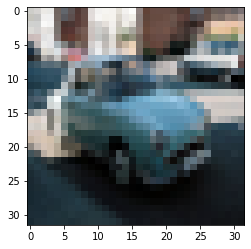

Ground truth label:  car
Fine tuned model's prediction: {'label': 'car', 'probability': '0.9968'}
Groud truth label: bird
Fine tuned model's prediction: {'label': 'frog', 'probability': '0.885'}
All tests passed


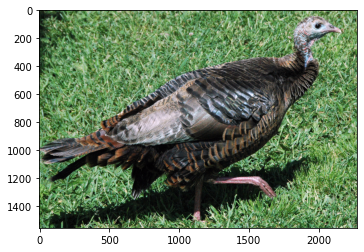

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

def test_deploy_model():
    # cifar-10 image
    cifar_img, label = full_valset[3]
    show_cifar_image(cifar_img)
    print("Ground truth label: ", classes[label])
    status_code, content = ping_endpoint(cifar_img.unsqueeze(0).numpy().tolist())
    assert status_code == 200
    assert content['trained_AlexNet.pt'] == {'label': 'car', 'probability': '0.9323'}
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.641'}
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.4759'}
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])

    # external image
    external_img = Image.open('test_img.jpg')
    plt.imshow(external_img)
    print("Groud truth label: bird")
    external_img_formatted = preprocess(external_img)
    status_code, content = ping_endpoint(external_img_formatted.tolist())
    assert content['trained_AlexNet.pt'] == {'label': 'bird', 'probability': '0.3377'}
    assert content['trained_LeNet.pt'] == {'label': 'car', 'probability': '0.3255'}
    assert content['trained_LogisticRegression.pt'] == {'label': 'car', 'probability': '0.7518'}
    print("Fine tuned model's prediction:", [pred for name, pred in content.items() if 'tuned' in name][0])
    
    print("All tests passed")

test_deploy_model()

If the status code is not 200 but 500+, you should print out the status code and the response content. This indicates a server issue, which likely comes from your `score.py`. Once you have fixed the issue, run the deployment code cells again and come back to this test case.

We see that for the first CIFAR-10 image, which depicts a car, all three classifiers were able to predict the label correctly, with LogisticRegression having the lowest confidence and AlexNet having the highest. For the second image, which depicts a bird but is not from CIFAR-10, the results are more mixed; LogisticRegression and LeNet think that this is also a car, but AlexNet is able to classify correctly again, though its confidence isn't too high (33%). In general, even CNN can run into trouble if the test data does not come from the same distribution as the training data. While this statement is true for most machine learning models, it does pose a challenge in computer vision, where input images may come from very different sources (e.g., cameras with different definitions).

What about your fine tuned model? How did it perform on these two test images? Feel free to try other images of any size as well!

**Managing endpoints**

You have completed all the questions in Project 5! One last step you need to do for this project, and for any other project that uses cloud resources (which you will encounter a lot in Cloud Computing), is to make sure you clean up your resources properly, so that no unexpected charge is incurred.

In the [primer](https://theproject.zone/m20-foundation-data-science/p5-machine-learning-azure-primer), we have shown you how to (1) create / delete resource group and (2) start / stop a compute in a resource group. After the deployment task, you now also have to manage the endpoints. As previously described, one way to remove an unused service endpoint is to call `service.delete()`; in case you no longer have access to the `service` variable (e.g., when you restart the kernel or log out of Azure), removing a service can also be done manually. Simply go to the "Endpoints" tab in the left navigation bar of the Azure Studio interface to see all of your current endpoints.

![endpoints](http://clouddatascience.blob.core.windows.net/m20-foundation-data-science/p5-model-deployment-comparison/managing_endpoints.png)

You can then select an endpoint to view information or to delete. If you have made a code submission to TPZ, our grader will send requests to your provided endpoint in `scoring_uri.txt`. Therefore, you should wait until you see your score on TPZ before deleting an endpoint. You should still stop the compute when you have finished working; endpoints can still be available without the compute running.